In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import subprocess

In [ ]:
# Set FSL environment variables
os.environ['FSLDIR'] = '/home/nathalie/fsl' 
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

In [5]:
#  Input T1 image 
t1_scan = '../test_data/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz'

#  Intermediate and final output paths 
bet_output = '../test_data/sub-116056_ses-3mo_T1w_brain'       # Output of BET (no extension)
fast_output_prefix = '../test_data/sub-116056_ses-3mo_FAST'    # Output of FAST

#  Run FSL BET (Brain Extraction) 
try:
    subprocess.run([
        'bet',
        t1_scan,
        bet_output,
        '-f', '0.4',     # Fractional intensity threshold (can tune for infants)
        '-g', '0',       # Vertical gradient
        '-R'             # Robust brain centre estimation
    ], check=True)
    print("BET (brain extraction) completed successfully.")
except subprocess.CalledProcessError as e:
    print("BET failed:", e)
    raise

#  Run FSL FAST on brain-extracted image 
try:
    subprocess.run([
        'fast',
        '-t', '1',             # Image type: 1 = T1-weighted
        '-n', '3',             # Number of tissue types (CSF, GM, WM)
        '-o', fast_output_prefix,
        bet_output + '.nii.gz'  # Use brain-extracted image
    ], check=True)
    print("FSL FAST completed successfully.")
except subprocess.CalledProcessError as e:
    print("FAST failed:", e)
    raise


BET (brain extraction) completed successfully.
FSL FAST completed successfully.


In [6]:
#  File paths 
base_path = '../test_data/'
prefix = os.path.join(base_path, 'sub-116056_ses-3mo_FAST')
t1_path = os.path.join(base_path, 'sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz')

#  Load images 
t1_img = nib.load(t1_path)
seg_img = nib.load(prefix + '_seg.nii.gz')            # hard segmentation: 0=CSF, 1=GM, 2=WM
pve_0 = nib.load(prefix + '_pve_0.nii.gz')             # CSF
pve_1 = nib.load(prefix + '_pve_1.nii.gz')             # GM
pve_2 = nib.load(prefix + '_pve_2.nii.gz')             # WM

#  Extract data arrays 
t1_data = t1_img.get_fdata()
seg_data = seg_img.get_fdata()
csf_pve = pve_0.get_fdata()
gm_pve = pve_1.get_fdata()
wm_pve = pve_2.get_fdata()

#  Calculate voxel volume in mL 
voxel_volume_mm3 = np.prod(t1_img.header.get_zooms())  # e.g., 1mm x 1mm x 1mm
voxel_volume_ml = voxel_volume_mm3 / 1000.0

#  Compute volumes from PVE maps 
csf_vol = np.sum(csf_pve) * voxel_volume_ml
gm_vol = np.sum(gm_pve) * voxel_volume_ml
wm_vol = np.sum(wm_pve) * voxel_volume_ml

print(f"CSF Volume: {csf_vol:.2f} mL")
print(f"GM Volume : {gm_vol:.2f} mL")
print(f"WM Volume : {wm_vol:.2f} mL")

CSF Volume: 265.70 mL
GM Volume : 346.79 mL
WM Volume : 573.10 mL


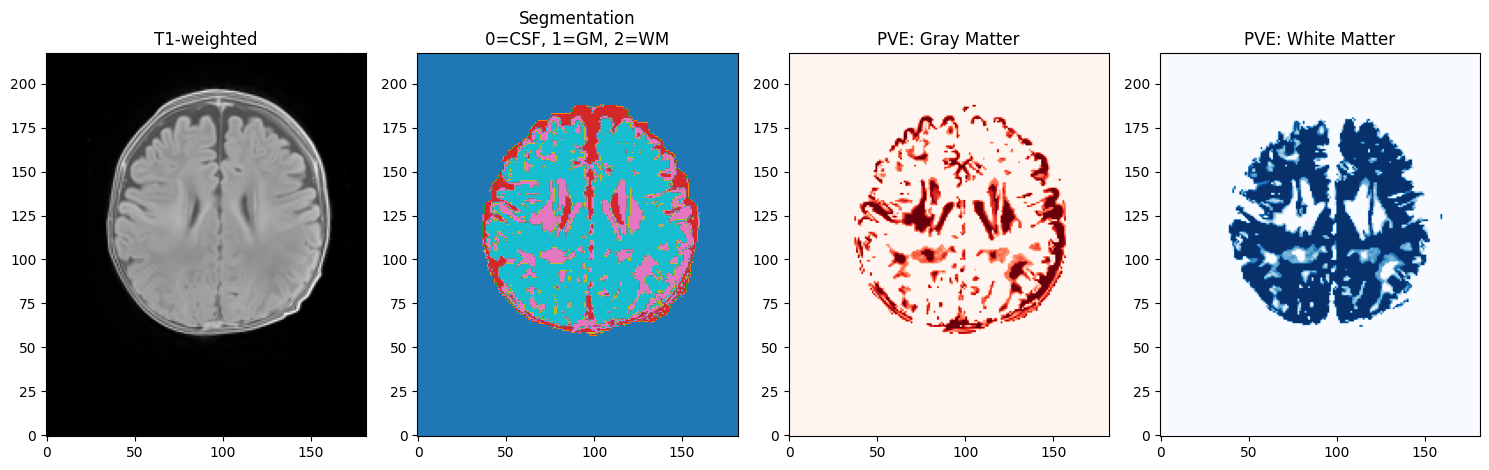

In [7]:
#  Visualise a middle slice 
slice_idx = t1_data.shape[2] // 2

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(t1_data[:, :, slice_idx].T, cmap='gray', origin='lower')
plt.title("T1-weighted")

plt.subplot(1, 4, 2)
plt.imshow(seg_data[:, :, slice_idx].T, cmap='tab10', origin='lower')
plt.title("Segmentation\n0=CSF, 1=GM, 2=WM")

plt.subplot(1, 4, 3)
plt.imshow(gm_pve[:, :, slice_idx].T, cmap='Reds', origin='lower')
plt.title("PVE: Gray Matter")

plt.subplot(1, 4, 4)
plt.imshow(wm_pve[:, :, slice_idx].T, cmap='Blues', origin='lower')
plt.title("PVE: White Matter")

plt.tight_layout()
plt.show()

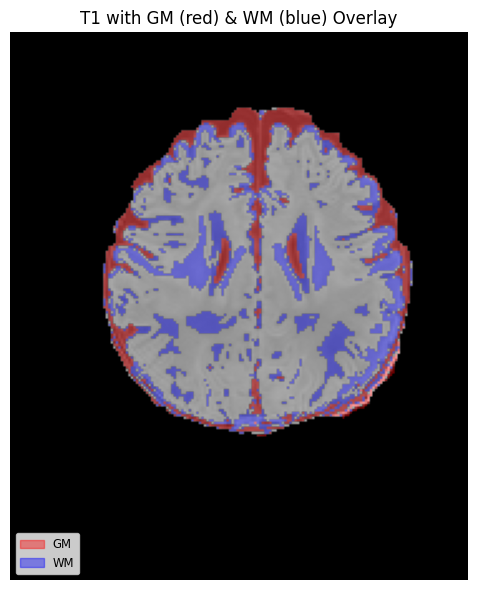

In [ ]:
def plot_t1_with_gm_wm_overlay(t1_path, seg_path, slice_idx=None, alpha=0.5):
    t1_img  = nib.load(t1_path)
    seg_img = nib.load(seg_path)
    t1 = t1_img.get_fdata()
    seg = seg_img.get_fdata().astype(int)
    
    # pick slice
    if slice_idx is None:
        slice_idx = t1.shape[2] // 2
    t1_slice  = t1[:, :, slice_idx].T
    seg_slice = seg[:, :, slice_idx].T

    # Normalize T1 
    t1_norm = (t1_slice - t1_slice.min()) / (t1_slice.ptp() + 1e-8)
    t1_rgb  = np.stack([t1_norm]*3, axis=-1)

    overlay = np.zeros((*seg_slice.shape, 4), dtype=float)

    # colours for GM and WM
    tissue_colors = {
        1: (1.0, 0.0, 0.0),  # GM = red
        2: (0.0, 0.0, 1.0),  # WM = blue
    }

    # Fill overlay channels
    for label, rgb in tissue_colors.items():
        mask = (seg_slice == label)
        overlay[..., 0][mask] = rgb[0]
        overlay[..., 1][mask] = rgb[1]
        overlay[..., 2][mask] = rgb[2]
        overlay[..., 3][mask] = alpha

    # plot T1 + overlay
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(t1_rgb,  origin='lower')
    ax.imshow(overlay, origin='lower')
    ax.set_title("T1 with GM (red) & WM (blue) Overlay")
    ax.axis('off')

    # Add legend
    legend_handles = [
        mpatches.Patch(color=(*tissue_colors[1], alpha), label='GM'),
        mpatches.Patch(color=(*tissue_colors[2], alpha), label='WM')
    ]
    ax.legend(handles=legend_handles, loc='lower left', fontsize='small')

    plt.tight_layout()
    plt.show()


t1_brain = '../test_data/sub-116056_ses-3mo_T1w_brain.nii.gz'
seg_path = '../test_data/sub-116056_ses-3mo_FAST_seg.nii.gz'

plot_t1_with_gm_wm_overlay(t1_brain, seg_path, alpha=0.4)


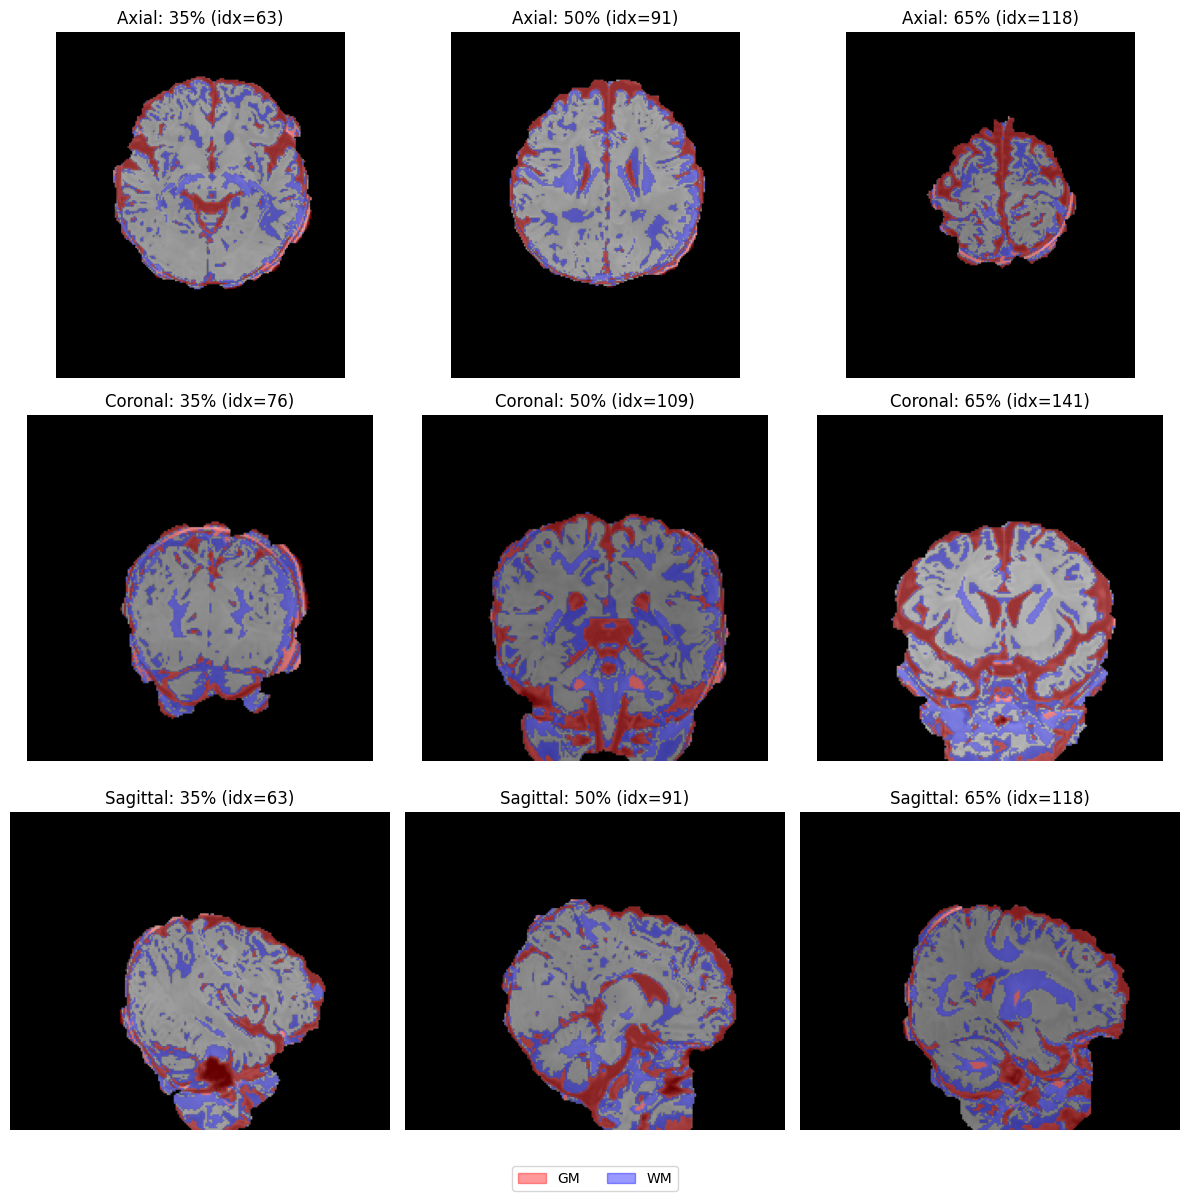

In [ ]:
def plot_3x3_views(t1_path, seg_path, alphas=(0.4, 0.4), fractions=(0.25, 0.5, 0.75)):
    """
    Displays a 3×3 grid of axial, coronal, and sagittal slices 
    with transparent GM & WM overlays.
    
    t1_path   : path to skull-stripped T1 .nii.gz
    seg_path  : path to FAST _seg.nii.gz
    alphas    : (gm_alpha, wm_alpha)
    fractions : positions along each axis (0–1)
    """
    # Load volumes
    t1_vol  = nib.load(t1_path).get_fdata()
    seg_vol = nib.load(seg_path).get_fdata().astype(int)
    
    # Normalize T1 once
    t1_norm = (t1_vol - t1_vol.min()) / (t1_vol.ptp() + 1e-8)
    
    # Build a full RGBA overlay volume
    overlay = np.zeros(t1_vol.shape + (4,), dtype=float)
    gm_mask = (seg_vol == 1)
    wm_mask = (seg_vol == 2)
    # GM in red channel
    overlay[..., 0][gm_mask] = 1.0
    overlay[..., 3][gm_mask] = alphas[0]
    # WM in blue channel
    overlay[..., 2][wm_mask] = 1.0
    overlay[..., 3][wm_mask] = alphas[1]
    
    # Prepare the figure
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    views = [('Axial', 2), ('Coronal', 1), ('Sagittal', 0)]
    
    for row, (_, axis) in enumerate(views):
        for col, frac in enumerate(fractions):
            idx = int(t1_vol.shape[axis] * frac)
            ax = axes[row, col]
            
            # Extract background slice and transpose
            if axis == 2:  # axial
                bg = t1_norm[:, :, idx].T
                ov = overlay[:, :, idx, :].transpose((1, 0, 2))
            elif axis == 1:  # coronal
                bg = t1_norm[:, idx, :].T
                ov = overlay[:, idx, :, :].transpose((1, 0, 2))
            else:  # sagittal
                bg = t1_norm[idx, :, :].T
                ov = overlay[idx, :, :, :].transpose((1, 0, 2))
            
            ax.imshow(bg, cmap='gray', origin='lower')
            ax.imshow(ov, origin='lower')
            ax.set_title(f"{views[row][0]}: {int(frac*100)}% (idx={idx})")
            ax.axis('off')
    
    # Single legend at bottom
    legend_patches = [
        mpatches.Patch(color=(1,0,0, alphas[0]), label='GM'),
        mpatches.Patch(color=(0,0,1, alphas[1]), label='WM')
    ]
    fig.legend(handles=legend_patches, loc='lower center', ncol=2, fontsize='medium')
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()


plot_3x3_views(t1_brain, seg_path, alphas=(0.4, 0.4), fractions=(0.35, 0.5, 0.65))
